In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Median Pay Change Analysis Using ADP's Research Institute Pay Insights Report

Anishi Patel

Data Source: https://payinsights.adp.com/?_ga=2.242148864.348414488.1714600535-2012619586.1714600535

### Data Overview:

The ADP Pay Insights Report is based on ADP payroll transaction data. The data includes select worker demographic information and firm characteristics. Each month, payroll data from about 17 million U.S. jobs are used to estimate the annual pay cited in this report. We track the same cohort of workers over a 12-month period to compute year-over-year change in pay for matched individuals. The matching process results in about 10 million individual pay change observations each month. Pay Insights covers both salary and wage workers. Salary workers make up about 39 percent of our sample; wage workers about 61 percent.

#### Pay

The Pay Insights Report tracks gross pay, which includes overtime, tips, bonuses, and commissions in addition to salary and hourly wages.

#### Annual pay

Our pay measures are job-based. Each job is a unique pairing of worker and employer. For each job, we observe actual total pay over the preceding 12 months to compute annual pay. If a job is paid only part of the year, an annual equivalent is estimated using the observed pay rate. We choose to calculate annual pay for the following reasons.

Hourly estimates are challenging if the hours associated with the pay amount are not provided.
A longer period of observation can eliminate short-term fluctuations in pay. For example, a bonus paid during a particular month will overstate a worker’s usual pay. A 12-month trailing measure of total pay not only smooths monthly variations, it also captures the full pay picture for the year.

#### Median annual pay change

Once individual annual pay is estimated, we match annual pay from the same job observed in both the current month and 12 months earlier. This matching process results in about 10 million individual pay-change observations each month. The median of the distribution of matched individuals’ year-over-year annual pay change is computed. There are negative median annual pay change values.

#### Job
Each job is a unique pairing of an individual worker and individual employer.

#### Job-stayer
If a job (the same employee-employer pairing) appears in both the current month and the same month from last year, its associated pay change will be included for job-stayers.

#### Job-changer
While our report focuses on the pay trajectories of job-stayers, we also track job-changers we observe. We are able to track only job-changers whose previous and current employers both are ADP clients.

#### State data
Geographic data is based on the primary location of the job, not the location of the worker.

<span style="color:darkgreen;">
    
### Load Data

</span>

In [36]:
# history is from October 2020 to April 2024
# timestep's M indicates month

pay_insights = pd.read_csv("ADP_PAY_history.csv")
pay_insights.tail()

,timestep,agg,category,date,median pay change,median annual pay
3177,M,Worker Type,Job Stayer,2023-12-01,5.4,58700.0
3178,M,Worker Type,Job Stayer,2024-01-01,5.3,58900.0
3179,M,Worker Type,Job Stayer,2024-02-01,5.1,59000.0
3180,M,Worker Type,Job Stayer,2024-03-01,5.1,59200.0
3181,M,Worker Type,Job Stayer,2024-04-01,5.0,59900.0


<span style="color:darkgreen;">
    
### Split dataset by "agg" type

</span>

In [97]:
# unique values in "agg" column: 'Age', 'Firm Size', 'Gender', 'Industry', 'State', 'Worker Type'
# Only job-stayers are included in sub-segments such as demographics, industry, and firm size.

age_pay_insights = pay_insights[pay_insights['agg'] == 'Age'] # 172 rows 
firmsize_pay_insights = pay_insights[pay_insights['agg'] == 'Firm Size'] # 215 rows
gender_pay_insights = pay_insights[pay_insights['agg'] == 'Gender'] # 86 rows
industry_pay_insights = pay_insights[pay_insights['agg'] == 'Industry'] # 430 rows
state_pay_insights = pay_insights[pay_insights['agg'] == 'State'] # 2193 rows
workertype_pay_insights = pay_insights[pay_insights['agg'] == 'Worker Type'] # 86 rows

age_pay_insights.tail()

,timestep,agg,category,date,median pay change,median annual pay
167,M,Age,Age 55-85,2023-12-01,3.6,59000.0
168,M,Age,Age 55-85,2024-01-01,3.6,60000.0
169,M,Age,Age 55-85,2024-02-01,3.4,59900.0
170,M,Age,Age 55-85,2024-03-01,3.4,60000.0
171,M,Age,Age 55-85,2024-04-01,3.5,60600.0


<span style="color:darkgreen;">
    
### EDA: visualize median pay change trends by aggregate group

</span>

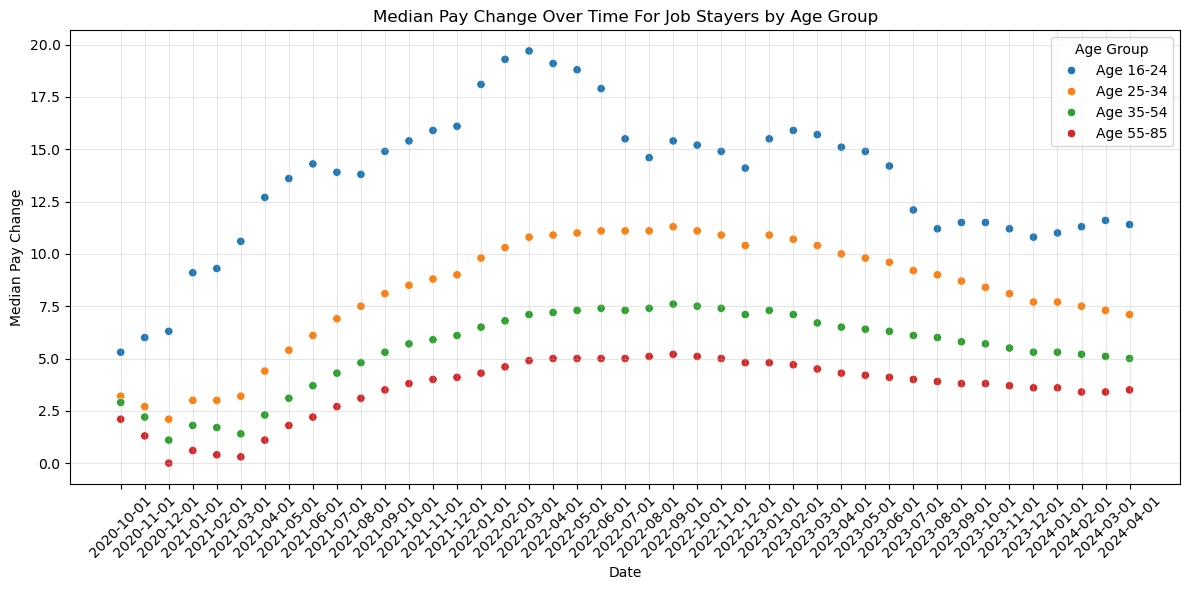

In [35]:
plt.figure(figsize=(12, 6))  # larger figsize for readability
sns.scatterplot(data=age_pay_insights, x='date', y='median pay change', hue='category')
plt.xlabel('Date')
plt.ylabel('Median Pay Change')
plt.title('Median Pay Change Over Time For Job Stayers by Age Group')
plt.xticks(rotation=45)  
plt.tight_layout() # prevents labels being clipped
plt.legend(title='Age Group')
plt.grid(alpha=0.3) # adds the grid
plt.show()

Looks like median pay change fluctuates most for job stayers in the age 16-24 bucket and has been trending down since March 2022. Other age groups were not affected and follow trends similar to each other, with people in the age 55-85 bucket experiencing very little fluctuation in median pay.

<span style="color:darkgreen;">
    
### EDA: visualize median annual pay trends by aggregate group

</span>

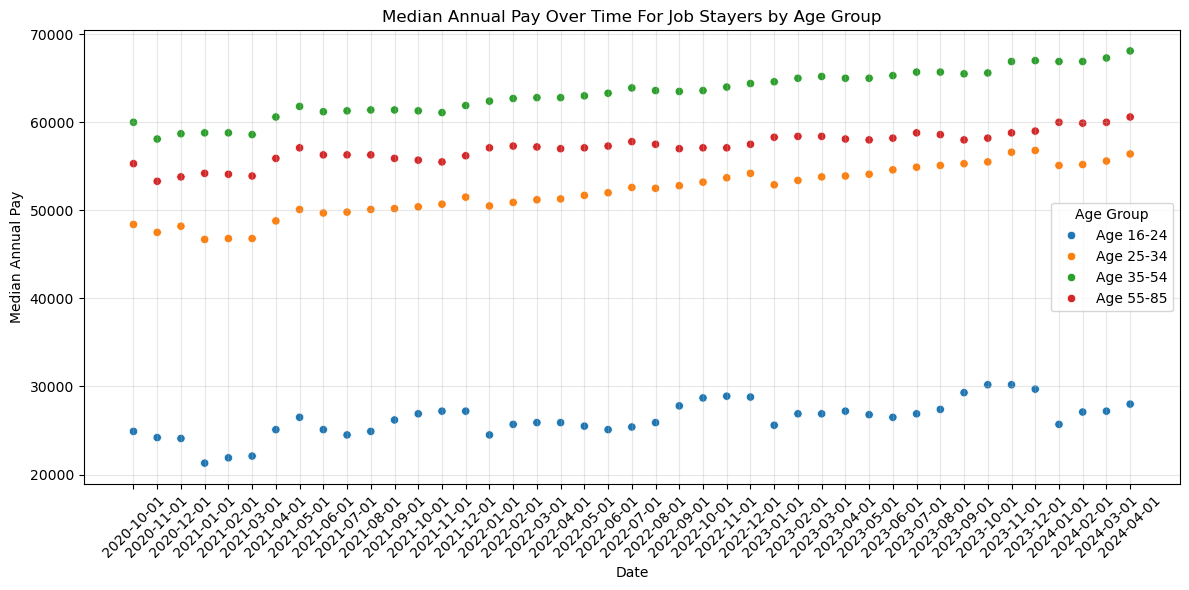

In [38]:
plt.figure(figsize=(12, 6))  # larger figsize for readability
sns.scatterplot(data=age_pay_insights, x='date', y='median annual pay', hue='category')
plt.xlabel('Date')
plt.ylabel('Median Annual Pay')
plt.title('Median Annual Pay Over Time For Job Stayers by Age Group')
plt.xticks(rotation=45)  
plt.tight_layout() # prevents labels being clipped
plt.legend(title='Age Group')
plt.grid(alpha=0.3) # adds the grid
plt.show()

Median annual pay is lowest for job stayers in the age 16-24 bucket, which is to be expected for employees beginning their careers, and highest for employees in the 35-54 range. This may indicate that earners in the 55-85 age bucket take pay cuts or transition to lower paying roles as they approach retirement.

<span style="color:darkgreen;">
    
### Predictive Modeling: Linear and Random Forest Regression on Age Data
We'll need to convert our categorical values (age buckets) to numerical values for use in the model

</span>

In [112]:
# split data into features (X) and target variable (y)
X = age_pay_insights.drop(["median pay change", "timestep", "agg"], axis = 1) # must specify axis
X['date'] = pd.to_datetime(X['date']) # date is in string format and cannot be used by the model as is
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['day'] = X['date'].dt.day
X = X.drop(['date'], axis=1)

y = age_pay_insights[["median pay change"]] # target var!

X_encoded = pd.get_dummies(X, columns=["category"])
X_encoded

,median annual pay,year,month,day,category_Age 16-24,category_Age 25-34,category_Age 35-54,category_Age 55-85
0,24900.0,2020,10,1,True,False,False,False
1,24200.0,2020,11,1,True,False,False,False
2,24100.0,2020,12,1,True,False,False,False
3,21300.0,2021,1,1,True,False,False,False
4,21900.0,2021,2,1,True,False,False,False
...,...,...,...,...,...,...,...,...
167,59000.0,2023,12,1,False,False,False,True
168,60000.0,2024,1,1,False,False,False,True
169,59900.0,2024,2,1,False,False,False,True
170,60000.0,2024,3,1,False,False,False,True


In [113]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 88) # using 20% of data in test set

In [114]:
# we'll do a linear regression first as a baseline (I don't expect a linear model to fit this data best, based on our EDA)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_y_pred = lr_model.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_y_pred))
print("Linear Regression Root Mean Squared Error:", lr_rmse)

Linear Regression Root Mean Squared Error: 2.336356534412911


In [115]:
# I expect a Random Forest model to fit the data better, so the RMSE should be lower for this model:

rf_model = RandomForestRegressor() # initializing model
rf_model.fit(X_train, y_train) # training model

rf_predictions = rf_model.predict(X_test)

# evaluate model using y_test set
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print("Random Forest Regression Root Mean Squared Error:", rf_rmse) # rmse is in same units as target var, MSE is not

Random Forest Regression Root Mean Squared Error: 1.093612519522863


/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/3173222957.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train) # training model


<span style="color:darkgreen;">
    
### Make predictions for May 2024 median annual pay

</span>

In [134]:
age_pay_insights[age_pay_insights['category'] == "Age 16-24"].tail(5)

,timestep,agg,category,date,median pay change,median annual pay
38,M,Age,Age 16-24,2023-12-01,10.8,29700.0
39,M,Age,Age 16-24,2024-01-01,11.0,25700.0
40,M,Age,Age 16-24,2024-02-01,11.3,27100.0
41,M,Age,Age 16-24,2024-03-01,11.6,27200.0
42,M,Age,Age 16-24,2024-04-01,11.4,28000.0


In [151]:
# we'll need to impute values for May 2024 median annual pay based on averages over the past 5 months for each age group

val4_impute = np.mean(age_pay_insights[age_pay_insights['category'] == "Age 55-85"]['median annual pay'].tail(5))
val3_impute = np.mean(age_pay_insights[age_pay_insights['category'] == "Age 35-54"]['median annual pay'].tail(5))
val2_impute = np.mean(age_pay_insights[age_pay_insights['category'] == "Age 25-34"]['median annual pay'].tail(5))
val1_impute = np.mean(age_pay_insights[age_pay_insights['category'] == "Age 16-24"]['median annual pay'].tail(5))
val2_impute

55820.0

In [152]:
# create a placeholder df with NaN values for May 2024, ages 55-85, to provide our rf model
may_2024_age4_data = pd.DataFrame(columns=X_encoded.columns)
may_2024_age4_data.loc[0] = [np.nan] * len(may_2024_age4_data.columns)

# we'll impute a value for "median annual pay" that is the average over the last 5 months (prev cell)
# and then we'll enter the correct date values and consider the Age 55-85 category only 
may_2024_age4_data['median annual pay'][0] = val4_impute
may_2024_age4_data['year'][0] = 2024
may_2024_age4_data['month'][0] = 5
may_2024_age4_data['day'][0] = 1
may_2024_age4_data.loc[0, 'category_Age 16-24'] = False
may_2024_age4_data.loc[0, 'category_Age 25-34'] = False
may_2024_age4_data.loc[0, 'category_Age 35-54'] = False
may_2024_age4_data.loc[0, 'category_Age 55-85'] = True
may_2024_age4_data # ignore error message for now, it's not causing issues

/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/2603215094.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  may_2024_age4_data.loc[0, 'category_Age 16-24'] = False
/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/2603215094.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  may_2024_age4_data.loc[0, 'category_Age 25-34'] = False
/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/2603215094.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype fir

,median annual pay,year,month,day,category_Age 16-24,category_Age 25-34,category_Age 35-54,category_Age 55-85
0,59900.0,2024.0,5.0,1.0,False,False,False,True


In [154]:
# do the same for the other age groups but add the correct imputed values and target group:

for data in [may_2024_age3_data, may_2024_age2_data, may_2024_age1_data]:
    data = may_2024_age4_data.copy() # copy the df for ages 55-85 for each age group
    data.loc[0, 'category_Age 55-85'] = False # set all encoded vars to false

# set the correct median annual pay val for each df
may_2024_age3_data['median annual pay'][0] = val3_impute
may_2024_age2_data['median annual pay'][0] = val2_impute
may_2024_age1_data['median annual pay'][0] = val1_impute

# set the correct age range encoded val to True for each df
may_2024_age1_data.loc[0, 'category_Age 16-24'] = True
may_2024_age2_data.loc[0, 'category_Age 25-34'] = True
may_2024_age3_data.loc[0, 'category_Age 35-54'] = True

/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/1140867131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may_2024_age3_data['median annual pay'][0] = val3_impute
/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/1140867131.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may_2024_age2_data['median annual pay'][0] = val2_impute
/var/folders/g5/yxrt7vrn59gfkx7gvwtq2cc00000gn/T/ipykernel_9242/1140867131.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [156]:
# Predict median pay change for May 2024
may_2024_age4_predictions = rf_model.predict(may_2024_age4_data)
may_2024_age3_predictions = rf_model.predict(may_2024_age3_data)
may_2024_age2_predictions = rf_model.predict(may_2024_age2_data)
may_2024_age1_predictions = rf_model.predict(may_2024_age1_data)

print("Random Forest model's median pay change predictions for all age buckets, oldest to youngest, in May 2024:")
print(may_2024_age4_predictions, may_2024_age3_predictions, may_2024_age2_predictions, may_2024_age1_predictions)

Random Forest model's median pay change predictions for all age buckets, oldest to youngest, in May 2024:
[3.561] [5.15] [7.398] [11.753]


<span style="color:darkgreen;">
    
### Plotting Model Predictions Alongside Historical Data

</span>

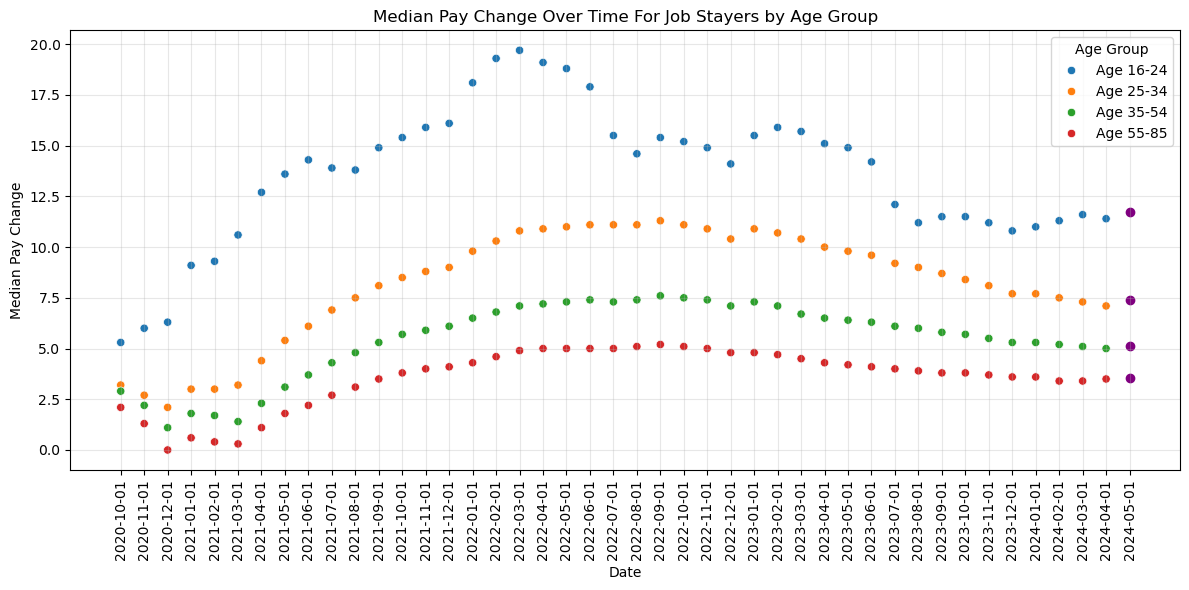

In [166]:
may_2024_data = {'Age 16-24': 3.561, 'Age 25-34': 5.15, 'Age 35-54': 7.398, 'Age 55-85': 11.753}

# re-plot the original median pay change graph
plt.figure(figsize=(12, 6))
sns.scatterplot(data=age_pay_insights, x='date', y='median pay change', hue='category')
plt.xlabel('Date')
plt.ylabel('Median Pay Change')
plt.title('Median Pay Change Over Time For Job Stayers by Age Group')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title='Age Group')

# add the May 2024 data points for each age group in purple
for category, median_pay_change in may_2024_data.items():
    plt.scatter('2024-05-01', median_pay_change, color='purple', label=f'May 2024 - {category}')

plt.grid(alpha=0.3)
plt.show()

<span style="color:darkgreen;">
    
### Conclusions

</span>

On average, our model predicts that individuals experienced a positive increase in their annual pay from April to May, compared to the previous year.

This is in line with our "Median Annual Pay Over Time For Job Stayers by Age Group" graph from earlier, which shows a positive trend in median annual pay for every age group.